In [2]:
import os
import numpy as np
from dask.distributed import Client
from dask import delayed
import dask.array as da
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.io import imread, imread_collection, imsave, ImageCollection

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Unsupervised Learning 

In this notebook, we will highlight a few applications of unsupervised learning to image data. 

## Kmeans for Color Quantization

Color Quantization is a process used to reduce the number of distinct colors used in an image. Limiting the number of colors helps to reduce the amount of memory required to store an image.  The goal of color quantization is to make the image look as close as possible to the original with as few colors as possible.   This example is inspired by [this sklearn demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py).

To demo color quantization we will use one of the images from the Design Safe dataset:

In [3]:
# read in image
img1 = imread('/tmp/Dataset_2/Validation/C0/3ea20934-f2c0-4cca-a034-dc503876ada2.jpg')
h,w,c = img1.shape
print('height:{}, width:{}, color:{}'.format(h,w,c))

height:2448, width:3264, color:3


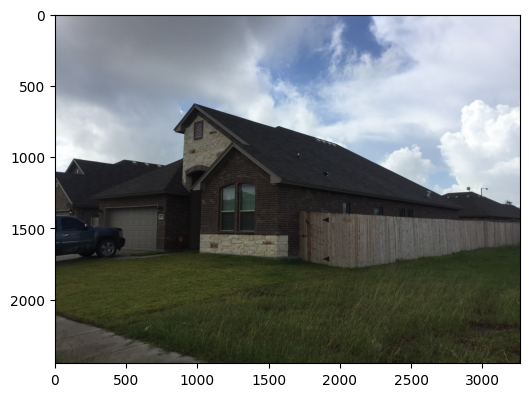

In [4]:
img1 = img1.astype('float')/ 255.
fig,ax=plt.subplots(figsize=(6,6))
ax.imshow(img1);

Next we will use kmeans to reduce the number of colors used in this image.  To do this we will cluster the RGB data for each pixel in the image.  By clustering the colors we can group colors that are the most similar to one another and use the color center as the new colors in the image. 

To get started we first need to reshape the image such that we have a vector of the colors of the various pixels. 

In [5]:
X = img1.reshape(-1,3)
X.shape

(7990272, 3)

Then we can run k-means on the colors in this image.  In this first example, we will select the number of clusters hyperparameter as 5. 

In [6]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=5).fit(X)

And get the cluster centers from the following attribute:

In [7]:
clf.cluster_centers_

array([[0.68712523, 0.74397969, 0.81623159],
       [0.15867836, 0.16753295, 0.11945362],
       [0.51804909, 0.56219305, 0.63483523],
       [0.31407364, 0.31124783, 0.26678852],
       [0.85110539, 0.883788  , 0.92699418]])

The 3 vectors above represent the three mean colors of the cluster produced.

We can also use the labels - an array of the integers describe the cluster each data point belongs to.

In [8]:
clf.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
len(clf.labels_)

7990272

Let's first create a contour map of the clusters

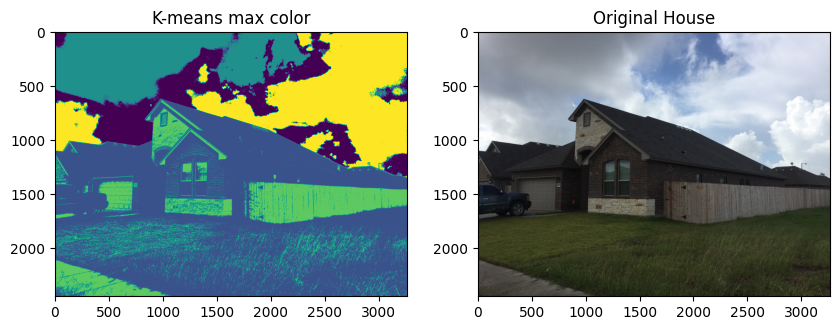

In [10]:
fig,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(clf.labels_.reshape((h,w)))
ax[0].set_title("K-means max color")
ax[1].imshow(img1)
ax[1].set_title('Original House');

Next, let's assign each cluster with a color that is the cluster center. 

Text(0.5, 1.0, 'Original House')

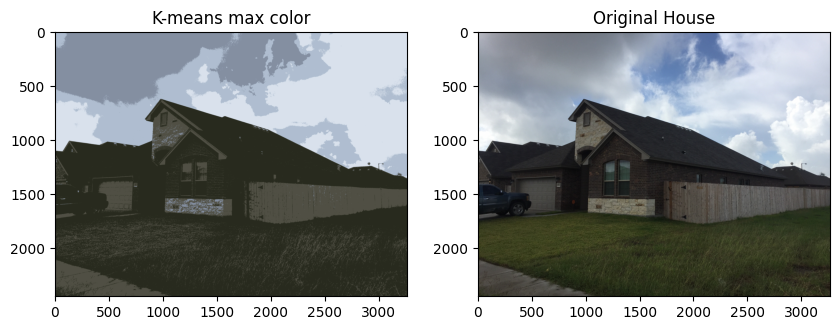

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
compressed_image = clf.cluster_centers_[clf.labels_]
ax[0].imshow(compressed_image.reshape((h,w,3)))
ax[0].set_title("K-means max color")
ax[1].imshow(img1)
ax[1].set_title('Original House')

We can see that there are five colors in the image aboove, but it clearly closely resembles the original image.

Finally, we can try out different values of k and see how many colors are needed to do a good job replicating the original image. 

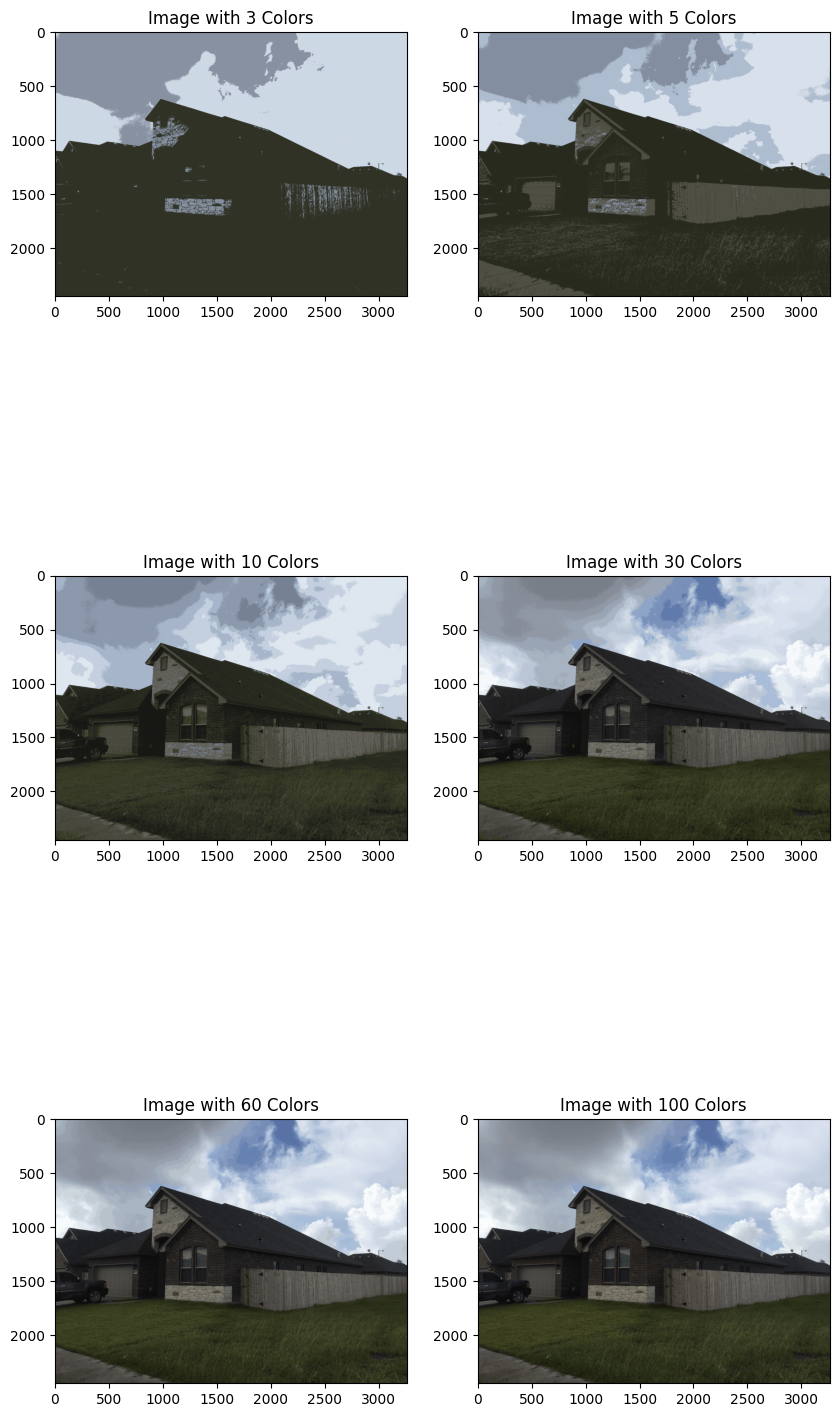

In [12]:
# Try different numbers of colors / value of k 
# It takes a long time to run
fig,axs = plt.subplots(3,2,figsize=(10,20))
ks = [3,5,10,30,60,100]
for ax,k in zip(axs.flatten(),ks):
    clf = KMeans(n_clusters=k).fit(X)
    compressed_image = clf.cluster_centers_[clf.labels_]
    ax.imshow(compressed_image.reshape((h,w,3)))
    ax.set_title('Image with {} Colors'.format(k))

## Image Compression with PCA  

In this demo, we will use Priciple Component Analysis(PCA) to find a lower dimensional representation of our data.

To do this, we will use the entire data set.  To get started we will import the images using an already existing script.

We use dask to speed things up.

### Get All Data from EDA pipeline

In [3]:
client = Client()

In [4]:
from src.get_data import get_all_data

# path to data
path_train = '/tmp/Dataset_2/Train/{}/'
path_test = '/tmp/Dataset_2/Validation/{}/'

### get number of images per classes in test and train
classes = np.array(['C0','C2','C4'])
path_list_train = [path_train.format(class_) for class_ in classes]
path_list_test = [path_test.format(class_) for class_ in classes]
        
train, test, y_train, y_test = get_all_data(path_list_train, path_list_test, classes, size=(112,112),gray=True)

/tmp/Dataset_2/Train/C0/
/tmp/Dataset_2/Train/C2/
/tmp/Dataset_2/Train/C4/
/tmp/Dataset_2/Validation/C0/
/tmp/Dataset_2/Validation/C2/
/tmp/Dataset_2/Validation/C4/


In [7]:
X_train = train.compute()

In [8]:
X_test = test.compute()

In [9]:
client.close()

2023-06-21 15:00:22,753 - distributed.nanny - WARNING - Worker process still alive after 3.199996795654297 seconds, killing
2023-06-21 15:00:22,755 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-06-21 15:00:22,756 - distributed.nanny - WARNING - Worker process still alive after 3.1999905395507815 seconds, killing
2023-06-21 15:00:22,757 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2023-06-21 15:00:22,759 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-06-21 15:00:22,759 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2023-06-21 15:00:22,760 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-06-21 15:00:22,761 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing


In [10]:
image_shape = X_train[0].shape

### Reshape Arrays

Next we will reshape the image data such that the images are stored not as matrices but as vectors. 

In [11]:
X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))
X_train.shape,X_test.shape

((1322, 12544), (363, 12544))

In the demo below create a lower dimensional representation of the image shown below. 

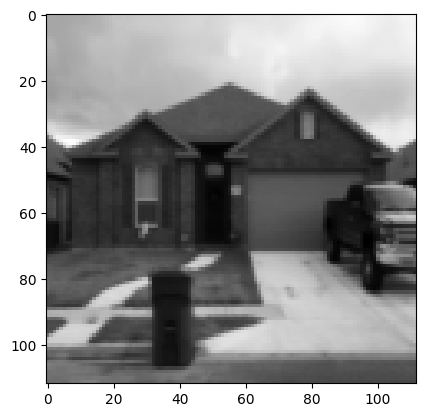

In [12]:
fig,ax=plt.subplots()
ax.imshow(X_train[0].reshape(image_shape),cmap='gray');

Next we will use PCA to find a lower dimensional representation of data.

In [13]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# standardize data before running PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

# Run PCA and transform the data to a lower dimensional represenation
pca = PCA(n_components=len(X_scaled))
X_train_pca = pca.fit_transform(X_scaled)

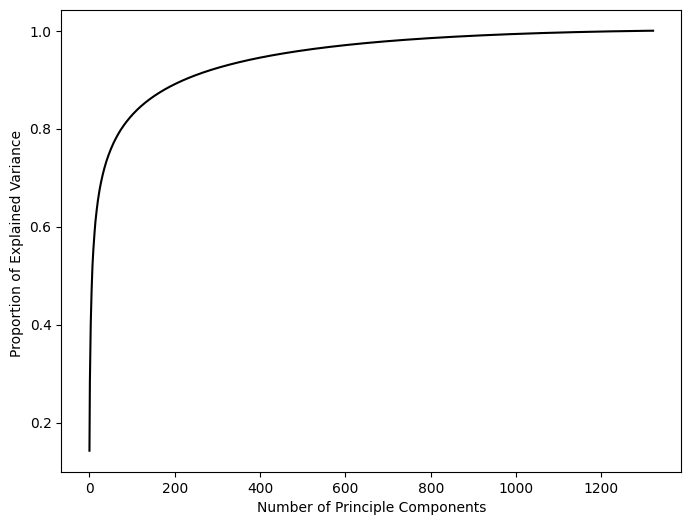

In [14]:
# view the proportion of explained variance with regards to the number of prenciple components. 
prop_var_expl = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='black')
ax.set_xlabel('Number of Principle Components')
ax.set_ylabel('Proportion of Explained Variance ');

Finally we can use a portion of our principal components from PCA to reconstruct the original image.  The less prinicpal components we use the less memory is required to store the image. However, the reconstructed image may deviate more from the original if we do not use a sufficient number.  

Below we vary the number of principal componenets used to reconstruct the image. 

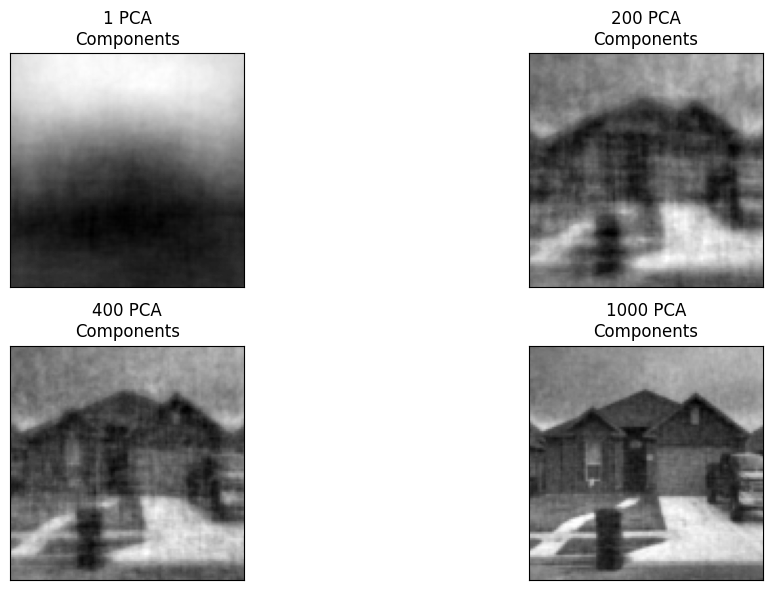

In [17]:
# view the lower dimension representation of our data 
# and see how good of a job is done replicating the original image
def reconstructed_housed(n_dim, data):
    eigenvalues = pca.components_[:n_dim, :].T
    house_reconstructed = data @ eigenvalues @ eigenvalues.T
    return house_reconstructed

fig, axs = plt.subplots(2, 2, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1,200,400,1000]):
    reduced_data = reconstructed_housed(dim,X_scaled)
    first_house = reduced_data[0].reshape(image_shape)
    ax.imshow(first_house, cmap='gray')
    ax.set_title("{} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()


### Image Compression

Using PCA we are able to represent images using 1 to 1000 features.  This is much lower than the original representation of $112\times112= 12,544$ dimensions.  

## Dimensionality Reduction with PCA for Supervised Learning Models

We can also use PCA to reduce the number of features that go into a supervised learning models

Next, Build models with reduced number of features created with PCA.  

In [37]:
# get functions from day2 demo in src folder
from sklearn.metrics import roc_curve, RocCurveDisplay, accuracy_score
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def evaluate(model, X_train, X_test, y_train, y_test, roc=True):
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    print('Accuracy on the Test Data is {:.2f}'.format(accuracy_test))
    print('Accuracy on the Training Data is {:.2f}'.format(accuracy_score(y_train, model.predict(X_train))))
    if roc:
        display = RocCurveDisplay(model, X_test, y_test) 
        display.plot()
    cm = confusion_matrix(y_test, model.predict(X_test), labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    return accuracy_test 

In [38]:
# build lr model
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0).fit(pca.transform(X_scaled), y_train)

Accuracy on the Test Data is 0.37
Accuracy on the Training Data is 1.00


0.371900826446281

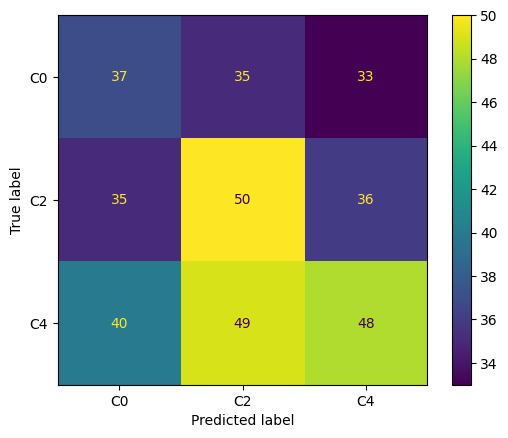

In [39]:
# evaluate model 
evaluate(clf_lr, pca.transform(X_scaled), pca.transform(scaler.transform(X_test)), y_train, y_test, roc=False)

Did using the lower dimensional representation help our model? 